# Deep Q Network with Noisy Networks for Exploration

## Imports

In [1]:
import gym
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
import math

from utils.wrappers import *
from utils.ReplayMemory import ExperienceReplayMemory
from networks.layers import NoisyLinear

## Hyperparameters

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#epsilon variables
SIGMA_INIT=0.5

#misc agent variables
GAMMA=0.99
LR=1e-4

#memory
TARGET_NET_UPDATE_FREQ = 1000
EXP_REPLAY_SIZE = 100000
BATCH_SIZE = 32

#Learning control variables
LEARN_START = 10000
MAX_FRAMES=700000

#Nstep controls
N_STEPS=1

#Categorical Params
ATOMS = 51
V_MAX = 10
V_MIN = -10

## Network

In [3]:
class CategoricalDQN(nn.Module):
    def __init__(self, input_shape, num_actions, sigma_init=0.5, atoms=51):
        super(CategoricalDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.atoms = atoms

        self.conv1 = nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.fc1 = NoisyLinear(self.feature_size(), 512, sigma_init)
        self.fc2 = NoisyLinear(512, self.num_actions*self.atoms, sigma_init)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x.view(-1, self.num_actions, self.atoms), dim=2)
    
    def feature_size(self):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *self.input_shape)))).view(1, -1).size(1)

    def sample_noise(self):
        self.fc1.sample_noise()
        self.fc2.sample_noise()

## Agent

In [4]:
class Model(object):
    def __init__(self, static_policy=False, env=None):
        super(Model, self).__init__()
        self.gamma=GAMMA
        self.lr = LR
        self.target_net_update_freq = TARGET_NET_UPDATE_FREQ
        self.experience_replay_size = EXP_REPLAY_SIZE
        self.batch_size = BATCH_SIZE
        self.learn_start = LEARN_START
        self.sigma_init = SIGMA_INIT
        self.atoms=ATOMS
        self.v_max=V_MAX
        self.v_min=V_MIN
        self.supports = torch.linspace(self.v_min, self.v_max, self.atoms).view(1, 1, self.atoms).to(device)
        self.delta = (self.v_max - self.v_min) / (self.atoms - 1)
        
        self.num_actions = env.action_space.n
        self.env = env

        self.static_policy=static_policy
        
        self.declare_networks()
            
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        #move to correct device
        self.model = self.model.to(device)
        self.target_model.to(device)

        if self.static_policy:
            self.model.eval()
            self.target_model.eval()
        else:
            self.model.train()
            self.target_model.train()

        self.update_count = 0

        self.memory = ExperienceReplayMemory(self.experience_replay_size)

        self.nsteps = N_STEPS
        self.nstep_buffer = []
    
    
    def declare_networks(self):
        self.model = CategoricalDQN(self.env.observation_space.shape, self.env.action_space.n, self.sigma_init, atoms=self.atoms)
        self.target_model = CategoricalDQN(self.env.observation_space.shape, self.env.action_space.n, self.sigma_init, atoms=self.atoms)

        
    def append_to_replay(self, s, a, r, s_):
        self.nstep_buffer.append((s, a, r, s_))

        if(len(self.nstep_buffer)<self.nsteps):
            return
        
        R = sum([self.nstep_buffer[i][2]*(self.gamma**i) for i in range(self.nsteps)])
        state, action, _, _ = self.nstep_buffer.pop(0)

        self.memory.push((state, action, R, s_))


    def prep_minibatch(self):
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(self.batch_size)
        
        batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)

        shape = (-1,)+self.env.observation_space.shape

        batch_state = torch.tensor(batch_state, device=device, dtype=torch.float).view(shape)
        batch_action = torch.tensor(batch_action, device=device, dtype=torch.long).squeeze().view(-1, 1)
        batch_reward = torch.tensor(batch_reward, device=device, dtype=torch.float).squeeze().view(-1, 1)
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=device, dtype=torch.uint8)
        try: #sometimes all next states are false
            non_final_next_states = torch.tensor([s for s in batch_next_state if s is not None], device=device, dtype=torch.float).view(shape)
            empty_next_state_values = False
        except:
            non_final_next_states = None
            empty_next_state_values = True

        return batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values

    def projection_distribution(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values = batch_vars

        with torch.no_grad():
            max_next_dist = torch.zeros((self.batch_size, 1, self.atoms), device=device, dtype=torch.float) + 1./self.atoms
            if not empty_next_state_values:
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                self.target_model.sample_noise()
                max_next_dist[non_final_mask] = self.target_model(non_final_next_states).gather(1, max_next_action)
                max_next_dist = max_next_dist.squeeze()


            Tz = batch_reward.view(-1, 1) + (self.gamma**self.nsteps)*self.supports.view(1, -1) * non_final_mask.to(torch.float).view(-1, 1)
            Tz = Tz.clamp(self.v_min, self.v_max)
            b = (Tz - self.v_min) / self.delta
            l = b.floor().to(torch.int64)
            u = b.ceil().to(torch.int64)
            l[(u > 0) * (l == u)] -= 1
            u[(l < (self.atoms - 1)) * (l == u)] += 1
            

            offset = torch.linspace(0, (self.batch_size - 1) * self.atoms, self.batch_size).unsqueeze(dim=1).expand(self.batch_size, self.atoms).to(batch_action)
            m = batch_state.new_zeros(self.batch_size, self.atoms)
            m.view(-1).index_add_(0, (l + offset).view(-1), (max_next_dist * (u.float() - b)).view(-1))  # m_l = m_l + p(s_t+n, a*)(u - b)
            m.view(-1).index_add_(0, (u + offset).view(-1), (max_next_dist * (b - l.float())).view(-1))  # m_u = m_u + p(s_t+n, a*)(b - l)

        return m
    
    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values = batch_vars

        batch_action = batch_action.unsqueeze(dim=-1).expand(-1, -1, self.atoms)
        batch_reward = batch_reward.view(-1, 1, 1)

        #estimate
        self.model.sample_noise()
        current_dist = self.model(batch_state).gather(1, batch_action).squeeze()

        target_prob = self.projection_distribution(batch_vars)
          
        loss = -(target_prob * current_dist.log()).sum(-1)
        loss = loss.mean()

        return loss

    def update(self, s, a, r, s_, frame=0):
        if self.static_policy:
            return None

        self.append_to_replay(s, a, r, s_)

        if frame < self.learn_start:
            return None

        batch_vars = self.prep_minibatch()

        loss = self.compute_loss(batch_vars)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        '''for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)'''
        self.optimizer.step()

        self.update_target_model()
        return loss.item()


    def get_action(self, s):
        with torch.no_grad():
            X = torch.tensor([s], device=device, dtype=torch.float)
            self.model.sample_noise()
            a = self.model(X) * self.supports
            a = a.sum(dim=2).max(1)[1].view(1, 1)
            return a.item()
            

    def update_target_model(self):
        self.update_count+=1
        self.update_count = self.update_count % self.target_net_update_freq
        if self.update_count == 0:
            self.target_model.load_state_dict(self.model.state_dict())

    def get_max_next_state_action(self, next_states):
        next_dist = self.target_model(next_states) * self.supports
        return next_dist.sum(dim=2).max(1)[1].view(next_states.size(0), 1, 1).expand(-1, -1, self.atoms)

    def finish_nstep(self):
        while len(self.nstep_buffer) > 0:
            R = sum([self.nstep_buffer[i][2]*(self.gamma**i) for i in range(len(self.nstep_buffer))])
            state, action, _, _ = self.nstep_buffer.pop(0)

            state = [state]
            action = [[action]]
            reward = [[R]]

            self.memory.push((state, action, reward, None))

    def huber(self, x):
        cond = (x < 1.0).float().detach()
        return 0.5 * x.pow(2) * cond + (x.abs() - 0.5) * (1.0 - cond)

## Plot Results

In [5]:
def plot(frame_idx, rewards, losses, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Training Loop

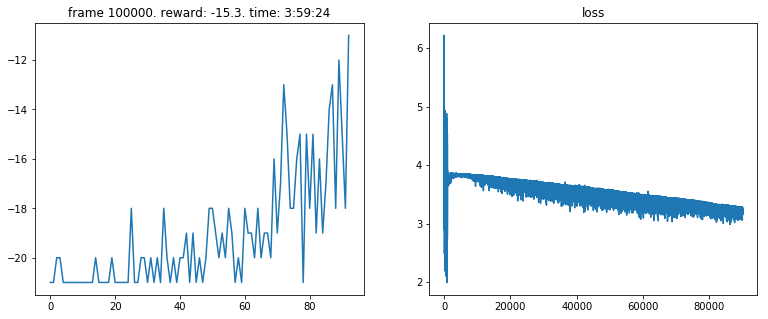

In [ ]:
start=timer()

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, frame_stack=True)
env    = wrap_pytorch(env)
model = Model(env=env)

losses = []
all_rewards = []
episode_reward = 0

observation = env.reset()
for frame_idx in range(1, MAX_FRAMES + 1):
    action = model.get_action(observation)
    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    loss = model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        observation = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
        if np.mean(all_rewards[-10:]) > 19:
            plot(frame_idx, all_rewards, losses, timedelta(seconds=int(timer()-start)))
            break

    if loss is not None:
        losses.append(loss)

    if frame_idx % 10000 == 0:
            plot(frame_idx, all_rewards, losses, timedelta(seconds=int(timer()-start)))


env.close()